# Policy Gradient in Reinforcement Learning (REINFORCE)

In Q-Learning, the next action is deterministically picked up based on a Q-function not on a Policy. Therefore we called it off-policy approach. The Policy is indirectly defined by the Q-Values, i.e., for every state we execute the action with the highest Q-value: $\pi(a|s) = argmax_a Q(s,a)$ where $\pi(a|s)$ is the policy function. $\pi(a|s)$ is the probability of taking action a given the state s. We parameterize the policy via a parameter $\theta$ as $\pi(a|s, \theta)$ , which allows us to determine the best action in a state.

In on-policy approaches, we learn the policy directly. Today, there exist a lot of advanced on-policy algorithms, here we look at the most basic form of on-policy learning 



In [11]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In policy gradient methods we want to maximize the expected discounted returns: 
$$J(\pi_{\theta}) = E_{\pi_\theta}(R) $$ 
where $R = \sum_{t = 0}^T \gamma^t r_t$.  Remember, in Q-Learning the Q-Value is also defined as the expected cumulative reward. In Q-Learning we approximate the Q-Value using the Bellmann Equation and Dynamic Programming. In the policy gradient method, we explicitly calculate R (see below). <br>

It can be shown that the gradient of this Objective function with respect to the parameters $\theta$ is: 
$$\Delta J \approx E[log\Delta\pi(a|s)R(s,a)]$$
This expression has a nice interpretation, which is as follows: 
Action Sensitivity: The log probability gradient $(log\Delta\pi(a|s))$ tells us how sensitive the action probability is to changes in the policy parameters. If a small change in the parameters significantly increases the probability of a beneficial action, we know that adjusting the parameters in that direction is useful.
Feedback Integration: The R provides the actual feedback on how good or bad the action was. If the reward is high, it means the action was beneficial; if it's low, the action wasn't great.
Combined Effect: By multiplying the log probability gradient with the reward, we get a combined measure that tells us how to adjust the policy parameters to favor actions that lead to higher rewards. If an action leads to a high reward and the log probability gradient is large, it means we should significantly increase the probability of taking that action in the future. 

> Note: For convenience, in stead of maximizing this Policy Gradient above we will be minimizing the negative Loss function in the code below: $L = - log\pi(a|s)R(s,a)$ which is equivalent. 

 The following Figure gives an intuition about the REINFORCE algorithm. 

![REINFORCE](../assets/REINFORCE.png)

Given the current Policy, choose best actions based on the highest probability coming from that network.  The Environment gives back a reward which is saved together with the log probabilities. Until the Episode is done, next best actions are executed and the respective rewards and log probabilities are stored. When the Episode is done, the loss is calculated and the policy is updated using gradient descent. 

Formally the Algorithm contains the following steps: 
1. Initialize the policy
2. Generate N full episodes and save the transitions (s,a,r,s')
3. For each step t in the episodes calculate the cumulated discounted reward for the remaining steps:<br>
 $R_t = \sum_{k = t+1}^T \gamma^{k-t-1} R_k$
4. Calculate the loss function for all transitions:<br>
 $L = \sum_{t = 1}^T  - R_tlog \pi(a_t|s_t)$ 
5. Update the policy
6. Continue from step 2 until convergence










In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits 

policy_pi = PolicyPi().to(device)

In [16]:
gamma = 0.99

# Pick up action with current policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = policy_pi(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt = torch.optim.AdamW(policy_pi.parameters(), lr=0.001)
for i in range(1500):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)
     
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    opt.zero_grad()
    logits = policy_pi(states)
    log_probs = F.log_softmax(logits,dim = 1)[range(len(states)),actions] 
    loss = -log_probs * cum_rewards
    loss.sum().backward()
    opt.step()

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

print("\nDone")
env.close()

Run episode1499 with rewards 500.0
Done


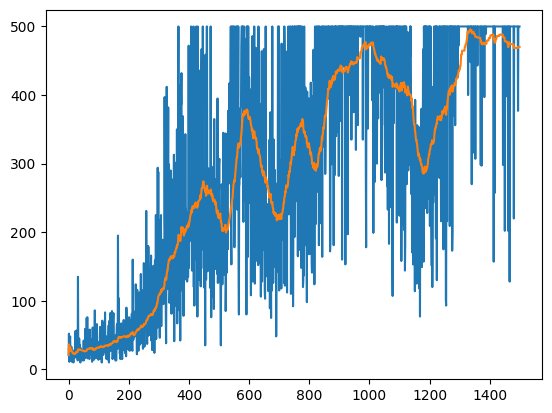

In [17]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(reward_records)
plt.plot(average_reward)